In [1]:
import pandas as pd
pd.set_option('display.max_columns', 60)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.figure_factory as ff
import plotly.express as px

In [2]:
data=pd.read_csv('../data/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016.csv')
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

In [3]:
data = data.replace({'Not Available': np.nan})

for col in list(data.columns):
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        data[col] = data[col].astype(float)

In [4]:
plt.figure(figsize=(10, 6))

fig=px.histogram(data, x="ENERGY STAR Score", nbins=100,labels={
                    "ENERGY STAR Score": "Score"},
                    title="Energy Star Score Distribution").update_layout(yaxis_title="Number of Buildings")

fig.update_traces(marker_line_width=1,marker_line_color="white")

fig.update_layout(
    margin=dict(l=20, r=40, t=40, b=20),
)
fig.show()

<Figure size 720x432 with 0 Axes>

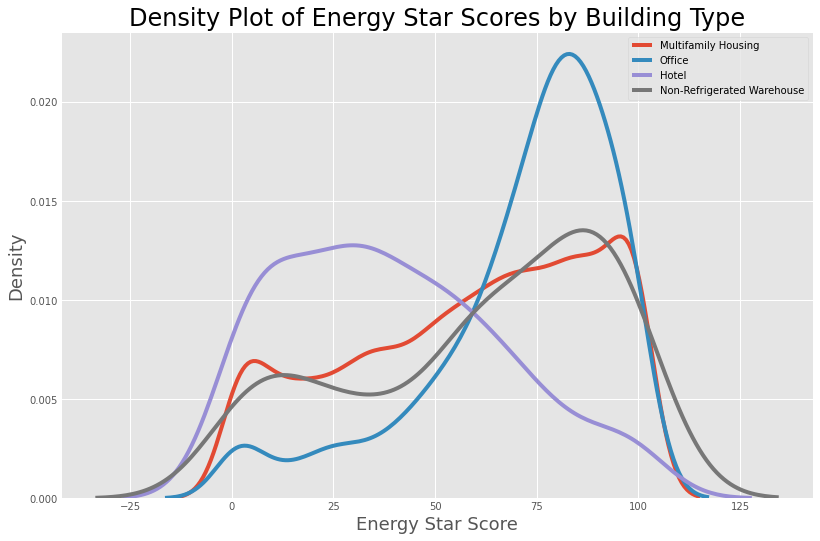

In [5]:
types=data.dropna(subset=['ENERGY STAR Score'])
types=types['Largest Property Use Type'].value_counts()
types=list(types[types.values>100].index) # use only types with 100+ observations in dataset
types

plt.style.use('ggplot')
plt.figure(figsize=(12,8))

for t in types:
    subset=data[data['Largest Property Use Type']==t]
    sns.kdeplot(subset['ENERGY STAR Score'].dropna(), label=t)

plt.xlabel('Energy Star Score', size=18)
plt.ylabel('Density', size=18)
plt.legend()
plt.title('Density Plot of Energy Star Scores by Building Type', size=24);

In [6]:
borogths_coors=data.groupby('Borough')[['Latitude', 'Longitude']].mean()
borogths_coors

,Latitude,Longitude
Borough,,
Bronx,40.853416,-73.893794
Brooklyn,40.647505,-73.964179
Manhattan,40.769400,-73.973757
Queens,40.656403,-73.799971
Staten Island,40.608601,-74.120329


In [7]:
borogths_score=pd.DataFrame(data.groupby('Borough')['ENERGY STAR Score'].mean())
borogths_score

,ENERGY STAR Score
Borough,
Bronx,57.690519
Brooklyn,62.985302
Manhattan,58.689426
Queens,61.585911
Staten Island,61.547619


In [11]:
val_counts=pd.DataFrame(data['Borough'].value_counts())
val_counts

,Borough
Manhattan,5176
Brooklyn,2265
Queens,2091
Bronx,1937
Staten Island,159


In [12]:
import folium

f = folium.Figure(width=700, height=700)
m = folium.Map(location=[40.7128, -74.0060], zoom_start=11).add_to(f)

for name, coors in zip(borogths_coors.index, borogths_coors.values):
    popup=f'''{name}<br>Coors: {coors}<br> Avg.Score: {borogths_score.loc[name].values[0]:.2f} 
    <br> No of Buildings: {val_counts.loc[name].values[0]}'''
    folium.Marker([coors[0], coors[1]], popup=popup, icon=folium.Icon(color='green', prefix='fa', icon='bolt')).add_to(m)

m

## Scatter

In [ ]:
def missing_values_df(df, n, bottom=False):
    missing_cols=df.isnull().sum()
    missing_cols_percent=(missing_cols/len(df)*100).round(2)
    missing_df=pd.DataFrame({'No. of Missing Values':missing_cols, 
                            '% of Missing Values':missing_cols_percent})
    print(f'{sum(np.where(missing_cols>0, 1, 0))} out of {len(missing_cols)} columns have NaNs')
    if bottom:
        final=missing_df.sort_values(by=missing_df.columns[0], ascending=False).replace({0:np.nan}).dropna()[-n:]
    else:
        final=missing_df.sort_values(by=missing_df.columns[0], ascending=False)[:n]
    return final

missing_values_df(data, 10)

46 out of 60 columns have NaNs


,No. of Missing Values,% of Missing Values
Fuel Oil #1 Use (kBtu),11737,99.92
Diesel #2 Use (kBtu),11730,99.86
Address 2,11539,98.24
Fuel Oil #5 & 6 Use (kBtu),11152,94.94
District Steam Use (kBtu),10810,92.03
Fuel Oil #4 Use (kBtu),10425,88.75
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.37
3rd Largest Property Use Type,10262,87.37
Fuel Oil #2 Use (kBtu),9165,78.03
2nd Largest Property Use - Gross Floor Area (ft²),8005,68.15


In [ ]:
all_missing=missing_values_df(data, data.shape[1])
cols_to_delete=list(all_missing[all_missing.iloc[:,1]>50].index)
print(f'{len(cols_to_delete)} columns to delete')

46 out of 60 columns have NaNs
11 columns to delete


In [ ]:
data.drop(columns=cols_to_delete, inplace=True)
print(f'Now we have {data.shape[1]} columns')

Now we have 49 columns


In [ ]:
q1, q3=data['Site EUI (kBtu/ft²)'].describe()[['25%', '75%']]
iqr=q3-q1

rows_before=data.shape[0]
data=data[(data['Site EUI (kBtu/ft²)']>(q1-3*iqr)) & (data['Site EUI (kBtu/ft²)']<(q3+3*iqr))]
diff=rows_before-data.shape[0]
print(f'There are {diff} outliers ({100*diff/data.shape[0]:.3f}%) our of {rows_before} rows')

There are 427 outliers (3.772%) our of 11746 rows


In [ ]:
feats=data[data['Largest Property Use Type'].isin(types)]

fig=px.scatter(feats, x='Site EUI (kBtu/ft²)', 
            y='ENERGY STAR Score', 
            color='Largest Property Use Type', title='Energy Star Score vs Site EUI',
            width=1000, height=700)
            
fig.update_layout(
    margin=dict(l=20, t=40, b=20),
)


In [ ]:
fig = px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
fig.show()